In [3]:
#create 1d cnn model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN1d(nn.Module):
    #create a 1d cnn regression model
    #the ouput is a target value of 60 minutes later, is a scalar
    def __init__(self, input_len, input_dim, kernel_size, layer_num, hidden_size,
                  dropout=0.5, batch_norm=True):
        #input shape: (batch_size, input_len, input_dim)
        super(CNN1d, self).__init__()
        self.input_len = input_len
        self.input_dim = input_dim
        self.kernel_size = kernel_size
        self.layer_num = layer_num
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.batch_norm = batch_norm
        self.convs = nn.ModuleList([nn.Conv1d(self.input_dim, self.hidden_size, self.kernel_size, padding=self.kernel_size // 2)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(self.hidden_size)])
        for i in range(self.layer_num - 1):
            self.convs.append(nn.Conv1d(self.hidden_size, self.hidden_size, self.kernel_size, padding=self.kernel_size // 2))
            self.bns.append(nn.BatchNorm1d(self.hidden_size))

        self.fc1 = nn.Linear(self.input_len * self.hidden_size, 74)
        self.dropout = nn.Dropout(self.dropout)
        self.init_weights()

    def init_weights(self):
        #initialize weights
        for conv in self.convs:
            torch.nn.init.xavier_uniform_(conv.weight)
        torch.nn.init.xavier_uniform_(self.fc1.weight)

    def forward(self, x):
        #forward pass
        #input shape: (batch_size, input_len, input_dim)
        #output shape: (batch_size, 1)
        x = x.transpose(1, 2)
        for i, conv in enumerate(self.convs):
            if self.batch_norm:
                x = F.relu(self.bns[i](conv(x)))
            else:
                x = F.relu(conv(x))
            x = self.dropout(x)

        x = x.view(-1, (self.input_len * self.hidden_size))
        x = self.fc1(x)

        return x
    
    def predict(self, x):
        #predict the target value
        return self.forward(x)
    
    def loss(self, x, y):
        #calculate loss
        return F.mse_loss(self.forward(x), y)




In [4]:
#positional encoding
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class PositionalEncoding(nn.Module):
    #add positional encoding to the input
    def __init__(self, input_len, input_dim, dropout=0.5):
        super(PositionalEncoding, self).__init__()
        self.input_len = input_len
        self.input_dim = input_dim
        self.dropout = nn.Dropout(dropout)
        self.pe = torch.zeros(self.input_len, self.input_dim)
        position = torch.arange(0, self.input_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.input_dim, 2).float() * (-math.log(10000.0) / self.input_dim))
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0)
        self.pe.requires_grad = False

    def forward(self, x):
        #forward pass
        #input shape: (batch_size, input_len, input_dim)
        #output shape: (batch_size, input_len, input_dim)
        x = x + self.pe
        return self.dropout(x)


In [5]:
class Attention(nn.Module):
    #create MULTIHEADATTENTION model
    #the ouput is a target value of 60 minutes later, is a scalar
    def __init__(self, input_len, input_dim, hidden_size, num_heads, layer_num, dropout=0.5):
        super(Attention, self).__init__()
        self.input_len = input_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.layer_num = layer_num
        self.dropout = dropout
        #embedding

        self.embedding = nn.Linear(self.input_dim, self.hidden_size)
        self.q_linears = nn.ModuleList([nn.Linear(self.hidden_size, self.hidden_size) for i in range(self.layer_num)])
        self.k_linears = nn.ModuleList([nn.Linear(self.hidden_size, self.hidden_size) for i in range(self.layer_num)])
        self.v_linears = nn.ModuleList([nn.Linear(self.hidden_size, self.hidden_size) for i in range(self.layer_num)])
        self.multihead_attns = nn.ModuleList([nn.MultiheadAttention(self.hidden_size, self.num_heads) for i in range(self.layer_num)])
        self.norms = nn.ModuleList([nn.BatchNorm1d(self.input_len) for i in range(self.layer_num)])
        self.out = nn.Linear(self.hidden_size * self.input_len, 74)

        self.dropout = nn.Dropout(dropout)
        self.pe = torch.zeros(self.input_len, self.hidden_size)
        position = torch.arange(0, self.input_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.hidden_size, 2).float() * (-math.log(10000.0) / self.hidden_size))
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0)
        self.pe.requires_grad = False
        self.init_weights()
        self.mean = nn.Parameter(torch.zeros(74))
        self.std = nn.Parameter(torch.ones(74))

    def init_weights(self):
        #initialize weights
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        torch.nn.init.xavier_uniform_(self.out.weight)
        
    def positional_encoding(self, x):
        #use positional encoding
        x = x + self.pe.to(x.device)
        return self.dropout(x)

    def forward(self, x):
        x = self.embedding(x)
        #use positional encoding
        x = self.positional_encoding(x)
        #forward pass
        bs = x.size(0)
        for i in range(self.layer_num):
            q = self.q_linears[i](x)
            k = self.k_linears[i](x)
            v = self.v_linears[i](x)
            x, _ = self.multihead_attns[i](q, k, v)
            x = self.norms[i](x)
            x = self.dropout(x)
        x = x.view(bs, -1)
        x = self.out(x)
        x = (x - self.mean) / self.std
        return x

    def loss(self, x, y):
        #calculate loss
        return F.mse_loss(self.forward(x), y)
    


In [6]:

num_samples = 1000
#test the model
X = torch.randn(num_samples, 4 * 74)
Y = torch.randn(num_samples, 74)


In [7]:
#data loader
day = torch.randint(0, 30, (num_samples, 1))
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, X, y, day, input_len=128):
        #the input data is a 1d array, indicate the minute of the day
        self.X = X
        self.y = y
        self.day = day
        self.input_len = input_len

    def __getitem__(self, index):
        #output previous self.input_len minutes data and target value
        #if the there is no enough data in the same day, pad with 0
        d = self.day[index]
        start = index - self.input_len
        if start < 0:
            start = 0
        if self.day[start] != d:
            while self.day[start] != d:
                start += 1
            #pad with 0 before start
        if index - start < self.input_len:
            x = torch.zeros(self.input_len, self.X.shape[1])
            x[self.input_len - index + start: self.input_len] = self.X[start: index].clone()
        else:
            x = self.X[start: index]
            
        y = self.y[index].clone()
        if x.shape != (self.input_len, self.X.shape[1]):
            print(x.shape, index, start)
        return x, y
    def __len__(self):
        return len(self.X)
    
mydataset = MyDataset(X, Y, day, input_len=120)
train_index = range(0, int(num_samples * 0.8))
test_index = range(0, int(num_samples * 0.8))
#test_index = range(int(num_samples * 0.8), num_samples)

train_dataset = torch.utils.data.Subset(mydataset, train_index)
test_dataset = torch.utils.data.Subset(mydataset, test_index)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)



In [8]:
#train the model with 4 GPUs
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import DataParallel

model = CNN1d(input_len=120, input_dim=74, kernel_size=3, layer_num=3, hidden_size=128, dropout=0.5, batch_norm=True)
def correlation_t(x, y):
    return torch.sum(x * y) / (torch.sqrt(torch.sum(x * x)) * torch.sqrt(torch.sum(y * y)))

optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
for epoch in range(100):
    prediction = []
    ground_truth = []
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        p = model(x)
        loss = F.mse_loss(p, y) + 0.01 * torch.sum(model.fc1.weight ** 2)
        prediction.append(p)
        ground_truth.append(y)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(epoch, i, loss.item())
    prediction = torch.cat(prediction, dim=0)
    ground_truth = torch.cat(ground_truth, dim=0)
    print(prediction.shape, ground_truth.shape)
    print(epoch, correlation_t(prediction, ground_truth).item())

#the number of gpu 
print(torch.cuda.device_count())



RuntimeError: Given groups=1, weight of size [128, 74, 3], expected input[128, 296, 120] to have 74 channels, but got 296 channels instead

In [8]:
class MLP(nn.Module):
    #create MLP model
    #the ouput is a target value of 60 minutes later, is a scalar
    def __init__(self, input_len, input_dim, hidden_size, layer_num, dropout=0.5):
        super(MLP, self).__init__()
        self.input_len = input_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.layer_num = layer_num
        self.dropout = dropout
        #embedding
        self.linears = nn.ModuleList([nn.Linear(self.input_dim, self.hidden_size)])
        self.norms = nn.ModuleList([nn.BatchNorm1d(self.input_len)])

        for i in range(self.layer_num - 1):
            self.linears.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.norms.append(nn.BatchNorm1d(self.input_len))

        self.out = nn.Linear(self.hidden_size * self.input_len, 74)
        self.dropout = nn.Dropout(dropout)
        self.init_weights()
        self.mean = nn.Parameter(torch.zeros(74))
        self.std = nn.Parameter(torch.ones(74))

    def init_weights(self):
        #initialize weights
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        torch.nn.init.xavier_uniform_(self.out.weight)

    def forward(self, x):
        #forward pass
        bs = x.size(0)

        for i in range(self.layer_num):
            x = self.linears[i](x)
            x = self.norms[i](x)
            x = self.dropout(x)
            x = F.relu(x)

        x = x.view(bs, -1)
        x = self.out(x)
        x = (x - self.mean) / self.std
        return x


In [16]:
class RNN(nn.Module):
    #create RNN model
    #the ouput is a target value of 60 minutes later, is a scalar
    def __init__(self, input_len, input_dim, hidden_size, layer_num, dropout=0.5, bidirectional=True):
        super(RNN, self).__init__()
        self.input_len = input_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.layer_num = layer_num
        self.dropout = dropout
        #embedding
        self.bidirectional = bidirectional
        self.rnn = nn.GRU(self.input_dim, self.hidden_size, self.layer_num, batch_first=True, dropout=self.dropout, bidirectional = self.bidirectional)
        self.out = nn.Linear(self.hidden_size * (1 + int(self.bidirectional)), 74)
        self.dropout = nn.Dropout(dropout)
        self.init_weights()


    def init_weights(self):
        #initialize weights
        torch.nn.init.xavier_uniform_(self.out.weight)

    def forward(self, x):
        #forward pass
        bs = x.size(0)
        x, hn = self.rnn(x)
        h = hn[-(1 + int(self.bidirectional)):]
        x = torch.cat(h.split(1), dim=-1).squeeze(0)
        x = self.out(x)

        return x

In [17]:
model = RNN(input_len=120, input_dim=296, hidden_size=128, layer_num=3, dropout=0.5)
def correlation_t(x, y):
    return torch.sum(x * y) / (torch.sqrt(torch.sum(x * x)) * torch.sqrt(torch.sum(y * y)))

optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
for epoch in range(100):
    prediction = []
    ground_truth = []
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        p = model(x)
        loss = F.mse_loss(p, y)
        prediction.append(p)
        ground_truth.append(y)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(epoch, i, loss.item())
    prediction = torch.cat(prediction, dim=0)
    ground_truth = torch.cat(ground_truth, dim=0)
    print(prediction.shape, ground_truth.shape)
    print(epoch, correlation_t(prediction, ground_truth).item())

0 0 1.0544946193695068


KeyboardInterrupt: 

In [22]:
class LSTM(nn.Module):
    #create LSTM model
    #the ouput is a target value of 60 minutes later, is a scalar
    def __init__(self, input_len, input_dim, hidden_size, layer_num, dropout=0.5, bidirectional=True):
        super(LSTM, self).__init__()
        self.input_len = input_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.layer_num = layer_num
        self.dropout = dropout
        #embedding
        self.bidirectional = bidirectional
        #activation function
        self.lstm = nn.LSTM(self.input_dim, self.hidden_size, self.layer_num, batch_first=True, dropout=self.dropout, bidirectional = self.bidirectional,
                            activation='relu')
        self.out = nn.Linear(self.hidden_size * (1 + int(self.bidirectional)), 74)
        self.dropout = nn.Dropout(dropout)
        self.init_weights()


    def init_weights(self):
        #initialize weights
        torch.nn.init.xavier_uniform_(self.out.weight)

    def forward(self, x):
        #forward pass
        bs = x.size(0)
        _, (hn, _)= self.lstm(x)
        h = hn[-(1 + int(self.bidirectional)):]
        x = torch.cat(h.split(1), dim=-1).squeeze(0)
        x = self.out(x)

        return x

In [23]:
model = LSTM(input_len=120, input_dim=296, hidden_size=128, layer_num=3, dropout=0.5)
def correlation_t(x, y):
    return torch.sum(x * y) / (torch.sqrt(torch.sum(x * x)) * torch.sqrt(torch.sum(y * y)))

optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
for epoch in range(100):
    prediction = []
    ground_truth = []
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        p = model(x)
        loss = F.mse_loss(p, y)
        prediction.append(p)
        ground_truth.append(y)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(epoch, i, loss.item())
    prediction = torch.cat(prediction, dim=0)
    ground_truth = torch.cat(ground_truth, dim=0)
    print(prediction.shape, ground_truth.shape)
    print(epoch, correlation_t(prediction, ground_truth).item())

0 0 1.031086802482605


KeyboardInterrupt: 

In [87]:
#tree models random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

X = torch.randn(num_samples, 4 * 74)
Y = torch.randn(num_samples, 1)
X = X.numpy()
Y = Y.numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#multiprocessing
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)


/var/folders/gw/rdd16gz922j8hc9s9c737lpw0000gr/T/ipykernel_67180/38055778.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=0)

In [26]:
#linear classifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

X = torch.randn(num_samples, 4 * 74)
# 4 classes
Y = torch.randint(0, 4, (num_samples, 1))
X = X.numpy()
Y = Y.numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
clf = SGDClassifier(loss="log", penalty="l2", max_iter=1000)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.23

In [15]:
#'04:00:00' to int
def time_to_int(time):
    #convert time to int
    #input time format: '04:00:00'
    #output int
    h, m, s = time.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

#int to '04:00:00'
def int_to_time(i):
    #convert int to time
    #input int
    #output time format: '04:00:00'
    h = i // 3600
    m = (i - h * 3600) // 60
    s = i - h * 3600 - m * 60
    return '%02d:%02d:%02d' % (h, m, s)

#convert time to int
a = time_to_int('04:00:00')
a -= 1
print(int_to_time(a))

03:59:59


In [78]:
#the std of the previous 60 minutes
#nan to 0 in np array
#inf to 0 in np array
#-inf to 0 in np array
x = np.array([1, 2, 3, np.nan])
x[np.isnan(x)] = 0
x[np.isinf(x)] = 0
x[np.isneginf(x)] = 0


In [79]:
df = pd.DataFrame([1, 1, np.inf, np.nan, -np.inf])
df.replace([np.inf, -np.inf], 0, inplace=True)

In [62]:
#for each row, normalize the mean and std of the previous 100 rows
df = pd.DataFrame(np.random.randn(1000, 3))
std = df.rolling(100).std().fillna(df.std())
mean = df.rolling(100).mean().fillna(df.mean())
df = (df - mean) / std



In [85]:
np.concatenate([np.zeros((1, 2)), np.ones((1, 2))])

array([[0., 0.],
       [1., 1.]])

In [70]:

df = pd.DataFrame(np.random.randn(1000, 3))
#assign [1, 5, 6] to each row
df.values[:] = [1, 5, 6]

In [88]:
#XGBoost Regressor

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np

X = torch.randn(num_samples, 4 * 74)
Y = torch.randn(num_samples, 1)
X = X.numpy()
Y = Y.numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
clf = HistGradientBoostingRegressor(max_iter=1000, learning_rate=0.1, max_depth=10, random_state=0)
clf.fit(X_train, y_train)



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor(max_depth=10, max_iter=1000, random_state=0)

In [1]:
import lightgbm as lgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import torch
num_samples = 1000
X = torch.randn(num_samples, 4 * 74)
Y = torch.randn(num_samples, 1)
X = X.numpy()
Y = Y.numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
param = {'num_leaves': 31, 'objective': 'regression', 'metric': 'l2'}
num_round = 1000
bst = lgb.train(param, train_data, num_round)
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
print(mean_squared_error(y_test, y_pred))




: 

: 

In [1]:
import pandas as pd
import numpy as np

df = pd.DataFrame(np.random.randn(5, 3))
df.index = [1, 2, 3, 4, 5]

In [9]:
df[0].index = [1, 2, 3, 1, 5]

In [5]:
u = df[1]
u.index = [1, 2, 3, 1, 5]

In [30]:
interval =  ['04:00:00', '05:00:00', '06:00:00', '07:00:00']
X = np.random.randn(4, 74)
Y = np.random.randn(4, 1)
#insert every minute into interval and fill corresponding position of X and Y with 0
def insert_interval(X, Y, interval):
    #insert every minute into interval and fill corresponding position of X and Y with 0
    #output X and Y
    X = pd.DataFrame(X)
    Y = pd.DataFrame(Y)

    #invert interval to int
    interval_t = [time_to_int(i) for i in interval]
    X.index = interval_t
    Y.index = interval_t

    #insert every minute into interval and fill corresponding position of X and Y with 0
    X = X.reindex(range(interval_t[0], interval_t[-1] + 1, 60)).fillna(0)
    Y = Y.reindex(range(interval_t[0], interval_t[-1] + 1, 60)).fillna(0)
    #position of interval_t in X.index
    pos = [X.index.get_loc(i) for i in interval_t]

    return list(X.index), X.values, Y.values, pos


In [2]:
!pip install lightgbm

  Using cached lightgbm-4.0.0.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lightgbm: filename=lightgbm-4.0.0-py3-none-macosx_13_0_arm64.whl size=1311735 sha256=0e08c39900e3169ae5ed39eda71385638edcb98c6da26e25b32358c348d3483d
  Stored in directory: /Users/binweiyan/Library/Caches/pip/wheels/87/b8/97/383847beeac44a4247d7c7f350f34f0dca66bbd9bc13e02403
Successfully built lightgbm


In [31]:
interval, X, Y, pos = insert_interval(X, Y, interval)

In [34]:
pd.DataFrame(interval_t)

NameError: name 'interval_t' is not defined

In [33]:
#add 5 to all the elements in l
l = [1, 2, 3]
l = [i + 5 for i in l]

TypeError: can only concatenate list (not "int") to list

In [37]:
X = np.random.randn(4, 74)
index = [1, 2]
X[index][:,range(8)] = 0


/var/folders/gw/rdd16gz922j8hc9s9c737lpw0000gr/T/ipykernel_94237/3180936425.py:5: RuntimeWarning: invalid value encountered in power
  X = np.random.normal(0, 1, 100000) ** 1.5


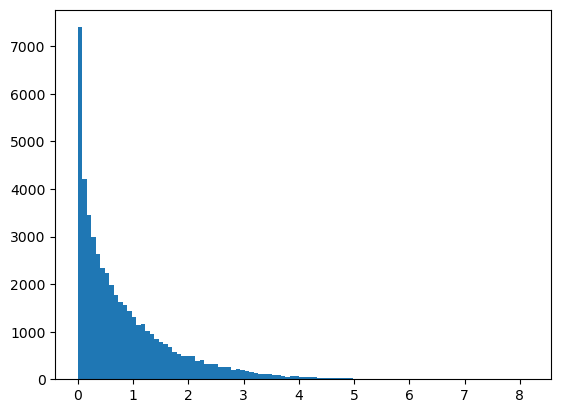

In [52]:
#normal distribution
import numpy as np
import matplotlib.pyplot as plt

X = np.random.normal(0, 1, 100000) ** 1.5
plt.hist(X, bins=100)
plt.show()

In [59]:
#pandas fill -inf with min value
import pandas as pd
X = pd.DataFrame(np.random.randn(100, 3))
X.iloc[0:10, 0] = -np.inf
X = X.replace(-np.inf, np.nan)
X = X.fillna(min(X.min()))

In [60]:
x = np.array([1, 2, 3, np.nan])
#count the number of nan
np.sum(np.isnan(x))

,0,1,2
0,-3.038437,0.785854,0.139290
1,-3.038437,0.348877,1.290593
2,-3.038437,0.940154,-0.762405
3,-3.038437,-1.022373,0.075832
4,-3.038437,-0.230745,0.880037
...,...,...,...
95,1.850661,0.511920,-0.356195
96,-1.506087,-0.490782,0.750037
97,2.268783,-1.446341,-0.239300
98,0.918332,-0.730611,-0.046762


In [ ]:
#select column not nan
X = pd.DataFrame(np.random.randn(100, 3))
X.iloc[0:10, 0] = np.nan
X = X[np.isnan(X.iloc[:, 0]) == False]

In [284]:
#generate average minute quote data
import pandas as pd

#df has columns: ['date', 'interval', 'msymbol_ukey', 'DD.askSize', 'DD.ask', 'DD.bid', 'DD.bidSize']
num_samples = 1000
df = pd.DataFrame(columns = ['date', 'interval', 'msymbol_ukey', 'DD.askSize', 'DD.ask', 'DD.bid', 'DD.bidSize'], 
                  index = range(num_samples))
df['date'] = '2020-01-01'
#generate random interval for each second
df['interval'] = pd.date_range('2020-01-01 04:00:00', periods=num_samples, freq='S')
df['interval'] = df['interval'].apply(lambda x: x.strftime('%H:%M:%S'))
df['msymbol_ukey'] = 1
df['DD.askSize'] = np.random.randn(num_samples)
df['DD.ask'] = np.random.randn(num_samples)
df['DD.bid'] = np.random.randn(num_samples)
df['DD.bidSize'] = np.random.randn(num_samples)
df['DD.isActive'] = np.random.randint(0, 2, num_samples)
df['DD.volBuy'] = np.random.randn(num_samples)
df['DD.volSell'] = np.random.randn(num_samples)
df['DD.ret'] = np.random.randn(num_samples)
df['DD.vol'] = np.random.randn(num_samples)
#get the average minute quote data

def get_average_minute_quote(df):
    #get the average minute quota data
    #input df
    #output df
    #df has columns: ['date', 'interval', 'msymbol_ukey', 'DD.askSize', 'DD.ask', 'DD.bid', 'DD.bidSize']
    #interval is in format of string '04:00:00'
    df['minute'] = df['interval'].apply(lambda x: x[0:5])
    ask = df.groupby(['date', 'minute', 'msymbol_ukey'])['DD.askSize'].transform(lambda x: np.mean(x))
    bid = df.groupby(['date', 'minute', 'msymbol_ukey'])['DD.bidSize'].transform(lambda x: np.mean(x))
    return pd.concat([ask, bid], axis=1)
#how many seconds is active in each minute
def get_active_seconds(df):
    #how many seconds is active in each minute
    #input df
    #output df
    #df has columns: ['date', 'interval', 'msymbol_ukey', 'DD.askSize', 'DD.ask', 'DD.bid', 'DD.bidSize', 'DD.isActive']
    #interval is in format of string '04:00:00'
    df['minute'] = df['interval'].apply(lambda x: x[0:5]) + ':00'
    #count the number of DD.active == 1 in each minute
    df['active_seconds'] = df.groupby( ['date', 'minute', 'msymbol_ukey'])['DD.isActive'].transform('sum')
    return df['active_seconds']

#how any times the ret goes from positive to negative in each minute
def get_ret_change_times(df):
    #how any times the ret goes from positive to negative in each minute
    df['minute'] = df['interval'].apply(lambda x: x[0:5]) + ':00'
    #how many times the ret goes from positive to negative in each minute
    #ignore 0

    df['non_zero_ret'] = df.groupby( ['date', 'minute', 'msymbol_ukey'] )['DD.ret'].transform(lambda x: x[x != 0])
    df['ret_change_times'] = df.groupby(['date', 'minute', 'msymbol_ukey'])['non_zero_ret'].transform( lambda x: np.sum(np.diff(np.sign(x)) != 0))

    return df['ret_change_times']

#quantile for each minute
def get_quantile(df, quantile = 3):
    #quantile for each minute
    #input df
    #output df
    #df has columns: ['date', 'interval', 'msymbol_ukey', 'DD.askSize', 'DD.ask', 'DD.bid', 'DD.bidSize']
    #interval is in format of string '04:00:00'
    df['minute'] = df['interval'].apply(lambda x: x[0:5]) + ':00'
    #return the mean of each quantile
    for i in range(quantile):
        df['quantile_' + str(i)] = df.groupby(['date', 'minute', 'msymbol_ukey'])['DD.ret'].transform( lambda x: np.mean(x[(x > np.quantile(x, i / quantile)) * ((x < np.quantile(x, (i + 1) / quantile)))]))
    return df[[col for col in df.columns if 'quantile' in col]]

#Entropy of a time horizon
def get_entropy(df, m, t):
    #Entropy of a time horizon
    #df has columns: ['date', 'interval', 'msymbol_ukey', 'DD.askSize', 'DD.ask', 'DD.bid', 'DD.bidSize']
    #interval is in format of string '04:00:00'
    #t is the time horizon
    #apply smoothing to each horizon m
    df['smooth'] = df['DD.ret'].rolling(m).mean()
    #get the entropy of each time horizon t
    def get_entropy(x):
        if len(x[x != 0]) == 0:
            return 0
        return -np.sum(x / np.sum(x) * np.log(x / np.sum(x)))
    df['entropy'] = df['smooth'].rolling(t).apply(get_entropy)
    return df['entropy']

#the acculmulated Buy - Sell imbalance
def get_imbalance(df):
    #the acculmulated Buy - Sell imbalance
    #df has columns: ['date', 'interval', 'msymbol_ukey', 'DD.askSize', 'DD.ask', 'DD.bid', 'DD.bidSize', 'DD.isActive', 'DD.volBuy', 'DD.volSell']
    #interval is in format of string '04:00:00'
    df['imbalance'] = df.groupby(['date', 'msymbol_ukey'])['DD.volBuy'].transform(lambda x: np.cumsum(x)) - df.groupby(['date', 'msymbol_ukey'])['DD.volSell'].transform(lambda x: np.cumsum(x))
    return df['imbalance']

#get the quantile of ret based on DD.vol quantile
def get_vol_quantile(df):
    #get the quantile of ret based on the mean of DD.vol quantile of the last minute
    #return vol quantile
    df['minute'] = df['interval'].apply(lambda x: x[0:5]) + ':00'
    df['vol_quantile'] = df.groupby(['date', 'minute'])['DD.vol'].transform(lambda x: np.mean(x[x != 0])).shift(60).fillna(0)   
    df['vol_quantile_pos'] = df['DD.vol'] > df['vol_quantile']
    df['vol_quantile_neg'] = (df['DD.vol'] < df['vol_quantile']) * (df['DD.vol'] != 0)
    df['pos_ret'] = df['DD.ret'] * df['vol_quantile_pos']
    df['neg_ret'] = df['DD.ret'] * df['vol_quantile_neg']
    df['pos_quantile'] = df.groupby(['date', 'minute'])['pos_ret'].transform('sum')
    df['neg_quantile'] = df.groupby(['date', 'minute'])['neg_ret'].transform('sum')
    df['pos_imbalance'] = df['DD.volBuy'] * df['vol_quantile_pos'] - df['DD.volSell'] * df['vol_quantile_pos']
    df['neg_imbalance'] = df['DD.volBuy'] * df['vol_quantile_neg'] - df['DD.volSell'] * df['vol_quantile_neg']
    return df[['pos_quantile', 'neg_quantile', 'pos_imbalance', 'neg_imbalance']]


In [287]:
df[100] = 0
x = get_entropy(df, 10, 10)
x[100:110]

100    2.136128
101    2.121062
102    2.156603
103    2.226293
104    2.248960
105    2.264669
106    2.270449
107    2.276232
108    2.284210
109    2.286192
Name: entropy, dtype: float64

In [233]:
df['DD.askSize'] > df['DD.bidSize']

0       True
1      False
2      False
3      False
4      False
       ...  
995    False
996     True
997    False
998    False
999     True
Length: 1000, dtype: bool

In [ ]:
#multithreading
import threading
import time
import random

def worker(arg):
    #thread worker function
    x, y = arg
    print(x, y)
    return

threads = []
#number of threads is max(1, number of cpu - 1)
num_threads = max(1, multiprocessing.cpu_count() - 1)
for i in range(500):
    t = threading.Thread(target=worker, args=((i, i + 1),))
    threads.append(t)

for i in range(500):
    threads[i].start()



In [202]:
quantile = 3
i = 0
f =  lambda x: np.mean(x[(x > np.quantile(x, i / quantile)) * ((x < np.quantile(x, (i + 1) / quantile)))])
f(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))

2.5

In [218]:
#integrate all the features
def get_features(df):
    #integrate all the features
    new = pd.DataFrame()
    new = pd.concat([new, get_average_minute_quote(df)], axis=1)
    new['active_seconds'] = get_active_seconds(df)
    new['ret_change_times'] = get_ret_change_times(df)
    new = pd.concat([new, get_quantile(df, quantile = 3)], axis=1)
    for m in [10, 30, 60]:
        for t in [10, 30, 60]:
            new['entropy_' + str(m) + '_' + str(t)] = get_entropy(df, m, t)
    new['imbalance'] = get_imbalance(df)
    new = pd.concat([new, get_vol_quantile(df, quantile = 3)], axis=1)
    new['date'] = df['date']
    new['minute'] = df['interval'].apply(lambda x: x[0:5]) + ':00'
    new['msymbol_ukey'] = df['msymbol_ukey']
    return new


In [215]:
np.diff(np.array([1, 2, 3, 4, 5, 6, 7, 8, -9, 10]))

array([  1,   1,   1,   1,   1,   1,   1, -17,  19])

In [219]:
new = get_features(df)
#squeeze the dataframe by squeezing the minute
new = new.groupby(['date', 'minute', 'msymbol_ukey']).mean().reset_index()

In [220]:
new

,date,minute,msymbol_ukey,DD.askSize,DD.bidSize,active_seconds,ret_change_times,quantile_0,quantile_1,quantile_2,...,entropy_60_10,entropy_60_30,entropy_60_60,imbalance,vol_quantile_0,imbalance_quantile_0,vol_quantile_1,imbalance_quantile_1,vol_quantile_2,imbalance_quantile_2
0,2020-01-01,04:00:00,1,0.153576,0.159888,32.0,28.0,-1.029904,0.040093,0.950497,...,NaN,NaN,NaN,8.189473,0.034226,-0.211545,0.029545,0.689109,-0.075620,0.379304
1,2020-01-01,04:01:00,1,0.070277,0.170257,37.0,25.0,-0.823792,0.102571,1.140267,...,0.403585,0.755708,2.989781,14.810075,0.261117,0.150261,-0.006286,-0.257019,0.125186,-0.291971
2,2020-01-01,04:02:00,1,0.132703,0.141176,23.0,28.0,-0.751911,0.447799,1.357787,...,3.346957,8.855843,12.950576,-1.988678,0.410844,0.000086,0.533422,-0.884480,0.026573,0.242825
3,2020-01-01,04:03:00,1,0.165413,0.215126,27.0,35.0,-0.775364,0.189733,1.158413,...,3.521326,10.673072,21.194466,-5.424806,0.409813,-0.123007,-0.247409,-0.501979,0.262230,0.278925
4,2020-01-01,04:04:00,1,-0.149525,0.029624,28.0,34.0,-0.933860,0.088822,1.207721,...,2.831463,9.135907,19.285445,-8.638203,-0.224793,0.103901,0.154870,-0.173902,0.259310,-0.057253
5,2020-01-01,04:05:00,1,-0.128483,0.044118,28.0,24.0,-1.148900,-0.050557,0.841266,...,0.829005,3.566250,11.005239,-14.218954,0.105987,0.125208,-0.285584,-0.485725,-0.215696,-0.144039
6,2020-01-01,04:06:00,1,0.235428,0.280623,32.0,31.0,-1.057598,-0.060052,0.945063,...,0.005229,0.005229,0.434104,-18.870400,0.102676,-0.231962,-0.185992,0.235239,-0.056506,-0.013393
7,2020-01-01,04:07:00,1,-0.072431,-0.253060,31.0,31.0,-1.066722,0.109472,0.965269,...,0.689714,1.683939,2.016381,-16.657134,0.049987,-0.033327,0.022358,0.373604,-0.155816,-0.897658
8,2020-01-01,04:08:00,1,-0.056604,-0.231385,26.0,27.0,-1.007138,0.259542,0.969862,...,0.423578,1.297306,3.256097,-15.261343,-0.194640,0.016368,0.086670,-0.282515,0.350880,0.133144
9,2020-01-01,04:09:00,1,-0.026685,0.216379,29.0,37.0,-1.113413,-0.042046,1.113367,...,0.727067,2.359666,4.585963,-37.607876,0.208946,-0.165622,-0.345881,-0.363368,0.068628,-0.514738


In [62]:
#'(1, 2, 5, 7)' into tuple
x = 'feat_(1, 2, 5, 7)_erfs'
x = x.split('_')
#position of 'feat'
x = x[x.index('feat') + 1]
x = tuple([int(i) for i in x[1:-1].split(',')])

In [82]:
pos = [1, 2, 3, 4, 5]
k = np.random.randn(5)
np.array(pos)[np.isnan(k)]

array([], dtype=int64)

In [222]:
#multiprocessing
import multiprocessing as mp
import time
import numpy as np
p = 5
def job(x):
    #do some job
    #time.sleep(1)
    return x ** 2

def multicore():
    #multiprocessing
    #input: None
    #output: None
    #return None
    pool = mp.Pool()
    #num of processes
    print(mp.cpu_count())
    res = pool.map(job, range(10))
    print(res)

multicore()

8


Process SpawnPoolWorker-21:
Process SpawnPoolWorker-19:
Process SpawnPoolWorker-23:
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/anaconda3/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/anaconda3/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/homebrew/anaconda3/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'job' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/anaconda3/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/

KeyboardInterrupt: 

In [223]:
#systime time in command line
!date


Sun Jul 30 17:30:48 EDT 2023


In [224]:
x = [1, 2, 3, 4, 5]
x[::-1]

[5, 4, 3, 2, 1]

In [289]:
#sum of previous 5 rows, not including current row
df = pd.DataFrame(np.random.randn(100, 3))
df['sum'] = df.rolling(5).sum().shift(1).fillna(0)

In [296]:
r = {}
r['a'] = [1, 2, 3]
r['b'] = [4, 5, 6]
r['c'] = [7, 8, 9]
#sort the dictionary by value's correlation with [0, 1, 2]
sorted(r.keys(), key=lambda x: np.corrcoef(np.array(r[x]), np.array([0, 1, 2]))[0,1], reverse=True)

['a', 'b', 'c']

In [297]:
#xgboost
import xgboost as xgb

model = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=1000, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#fscore
model.get_fscore()


NameError: name 'X_train' is not defined

In [309]:
#approximate entropy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def ApEn(U, m, r):

    #Approximate Entropy
    #input: U: time series
    #       m: embedding dimension
    #       r: tolerance
    #output: ApEn(U, m, r)
    #U is a time series
    #m is the embedding dimension
    #r is the tolerance

    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0) ** (-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m + 1) - _phi(m))

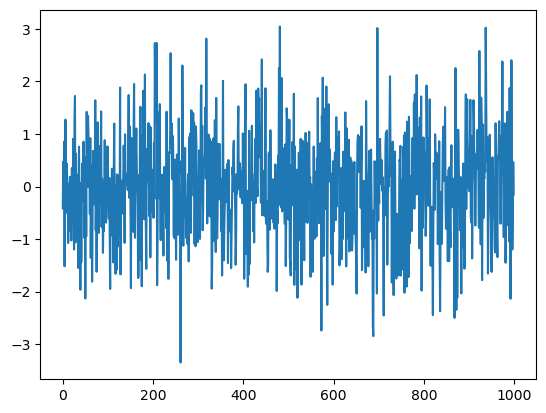

998
999
1.6452628576795751


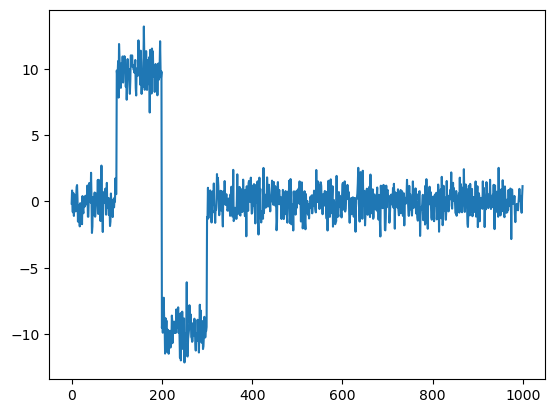

998
999
1.3430070468566404


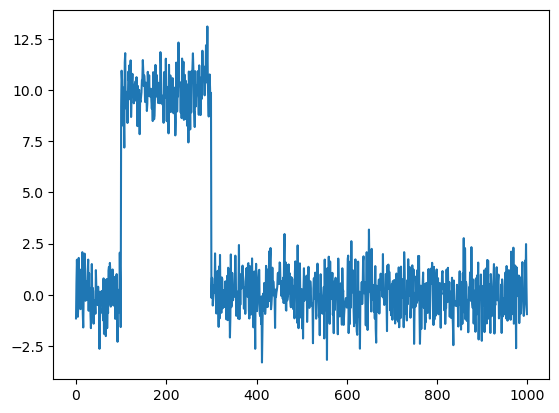

998
999
1.4077940448883393


In [311]:
#test
U = np.random.randn(1000)
plt.plot(U)
plt.show()
print(ApEn(U, 2, 0.2))
U2 = np.random.randn(1000)
U2[100:200] = U2[100:200] + 10
U2[200:300] = U2[200:300] - 10
plt.plot(U2)
plt.show()
print(ApEn(U2, 2, 0.2))
U3 = np.random.randn(1000)
U3[100:200] = U3[100:200] + 10
U3[200:300] = U3[200:300] + 10
plt.plot(U3)
plt.show()
print(ApEn(U3, 2, 0.2))


In [312]:
import numpy as np
def correlation(x, y):
    x = np.array(x)
    y = np.array(y)
    return x @ y / (np.sqrt(x @ x) * np.sqrt(y @ y))

def get_correlation(data, i, j):
    #get the correlation of time series 0 to i and j to i + j
    #data has columns: ['date', 'interval', 'msymbol_ukey', 'DD.ret']

    r = data['ret'].fillna(0)
    def get_corr(x):
        return correlation(x[0:i], x[j:i + j])
    r = r.rolling(i + j).transform(get_corr).fillna(0)

In [ ]:
def get_sparsity(data)
    #get the sparsity of the time series, times return by sparsity

    #sparsity is the number of zero between the previous non-zero and the next non-zero
    data['sparsity'] = 0
    data['sparsity'] = data['sparsity'].where(data['ret'] == 0, 1)
    #get the sum of each consecutive sevral 1
    data['sparsity'] = data['sparsity'].rolling(10).sum().fillna(0)
    #sum of sparsity*ret
    data['sparsity'] = data['sparsity'] * data['ret']
    return data['sparsity'].groupby(['minute']).sum()

In [323]:
#AutoEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class AutoEncoder(nn.Module):
    #AutoEncoder
    def __init__(self, input_len, input_dim, hidden_size, layer_num, dropout=0.5, bidirectional=True):
        super(AutoEncoder, self).__init__()
        self.input_len = input_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.layer_num = layer_num
        self.dropout = dropout
        self.bidirectional = bidirectional
        #embedding
        self.encoder = nn.GRU(self.input_dim, self.hidden_size, self.layer_num, batch_first=True, dropout=self.dropout, bidirectional = self.bidirectional)
        self.decoder = nn.GRU(self.hidden_size * 2, self.hidden_size, self.layer_num, batch_first=True, dropout=self.dropout, bidirectional = self.bidirectional)
        self.out = nn.Linear(self.hidden_size * (1 + int(self.bidirectional)), self.input_dim)
        self.init_weights()


    def init_weights(self):
        #initialize weights
        pass

    def forward(self, x):
        #forward pass
        bs = x.size(0)
        x, hn = self.encoder(x)
        x, hn = self.decoder(x)
        print(x.shape)
        output = self.out(x)
        return output

    def loss(self, x, y):
        #loss function
        return F.mse_loss(x, y)

#test
model = AutoEncoder(input_len=120, input_dim=100, hidden_size=32, layer_num=2, dropout=0.5)
x = torch.randn(5, 120, 100)
p = model(x)
print(p.shape)
loss = model.loss(p, x)
print(loss)



torch.Size([5, 120, 64])
torch.Size([5, 120, 100])
tensor(1.0210, grad_fn=<MseLossBackward0>)


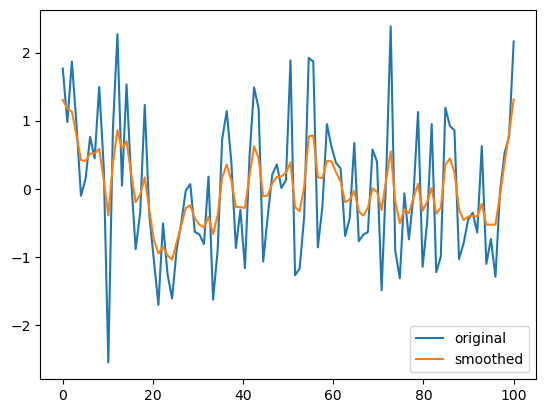

In [329]:
#kalmann filter
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

#generate data
np.random.seed(0)
x = np.linspace(0, 100, 100)
#y is 2 dimensional
y = np.random.randn(100, 2)

#apply kalman filter of dimension 2
kf = KalmanFilter(n_dim_obs=2,
                    transition_matrices=np.eye(2),
                    observation_matrices=np.eye(2) * 1.1)
kf = kf.em(y, n_iter=5)
#smooth the data
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(y)

#plot the data
plt.plot(x, y[:, 0], label='original')
plt.plot(x, smoothed_state_means[:, 0], label='smoothed')
plt.legend()
plt.show()

